# Stock Market Prediction using CNN-LSTM model

*This is modified from the original. See [README](./README.md) for more information.

This project is about analysis of Stock Market and providing predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

# Warnings

- There are tons of them, disable

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing and Analysis

In [2]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [3]:
from dotenv import load_dotenv
import requests
import csv
from tqdm import tqdm
import os

load_dotenv()

ALPHA_VANTAGE_API_KEY = os.environ.get('ALPHA_VANTAGE_API_KEY', None)
assert ALPHA_VANTAGE_API_KEY is not None, "Please set the ALPHA_VANTAGE_API_KEY environment variable with your Alpha Vantage API key."


def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize={}&apikey={}'
    
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 5))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "volume"]
    df['date'] = date
    return df

In [4]:
# UNCOMMENT THE CELL IF DATA IS NEEDED TO BE LOADED FOR 1ST TIME
TICKER = 'IBM'

if not os.path.exists('data.csv'):
    print("Data file not found. Downloading stock data...")
    cv1 = request_stock_price_list(TICKER, 'full', ALPHA_VANTAGE_API_KEY)
    print(f"Data has been successfully downloaded {TICKER}")
    cv1.to_csv('data.csv')
else:
    print(f"Using cached data file for {TICKER}...")

Using cached data file for IBM...


Then the datasets are loaded

In [5]:
import pandas as pd
# For data preprocessing and analysis part
# data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/abe.us.txt')
#data = pd.read_csv('../input/nifty50-stock-market-data/COALINDIA.csv')
#data = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ABCO.csv')
data = pd.read_csv('./data.csv', parse_dates=['date'])
# Any CSV or TXT file can be added here....
data = data.rename(columns={'date': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
data.head()

,Unnamed: 0,Open,High,Low,Close,Volume,Date
0,0,285.000,286.9100,282.9400,283.21,3534110,2025-06-18
1,1,281.150,284.7899,281.0001,283.05,3069556,2025-06-17
2,2,279.305,284.5000,278.6657,281.83,3685321,2025-06-16
3,3,278.205,279.8400,275.8300,277.22,3243824,2025-06-13
4,4,281.530,283.0600,279.8300,281.03,3418007,2025-06-12


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6447 entries, 0 to 6446
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  6447 non-null   int64         
 1   Open        6447 non-null   float64       
 2   High        6447 non-null   float64       
 3   Low         6447 non-null   float64       
 4   Close       6447 non-null   float64       
 5   Volume      6447 non-null   int64         
 6   Date        6447 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 352.7 KB


In [7]:
data.set_index('Date', inplace=True)
data.describe()

,Unnamed: 0,Open,High,Low,Close,Volume
count,6447.000000,6447.000000,6447.000000,6447.000000,6447.000000,6.447000e+03
mean,3223.000000,134.424597,135.654797,133.278648,134.500566,5.866857e+06
std,1861.232925,39.828675,40.008980,39.672553,39.883148,3.286362e+06
min,0.000000,54.650000,56.700000,54.010000,55.070000,1.027500e+06
25%,1611.500000,102.780000,104.410000,101.335000,102.900000,3.713950e+06
50%,3223.000000,130.010000,131.080000,128.950000,130.020000,5.010600e+06
75%,4834.500000,160.130000,161.370000,159.097500,160.240000,7.070184e+06
max,6446.000000,285.000000,286.910000,282.940000,283.210000,4.120730e+07


In [8]:
data.isnull().sum()

Unnamed: 0    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

Filling null columns with mean values....

In [9]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

,Unnamed: 0,Open,High,Low,Close,Volume
0,0,285.000,286.9100,282.9400,283.21,3534110
1,1,281.150,284.7899,281.0001,283.05,3069556
2,2,279.305,284.5000,278.6657,281.83,3685321
3,3,278.205,279.8400,275.8300,277.22,3243824
4,4,281.530,283.0600,279.8300,281.03,3418007


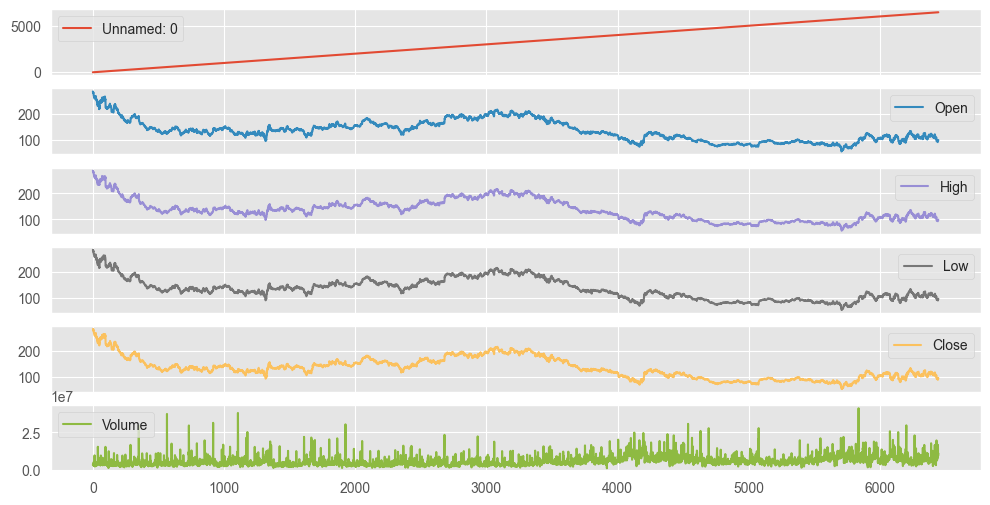

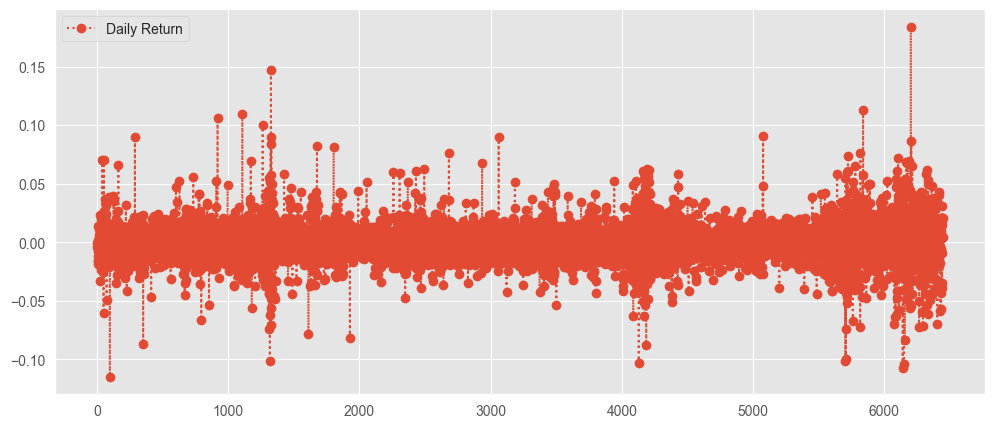

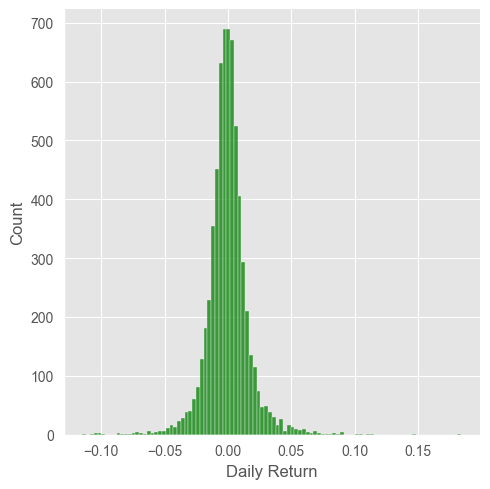

      Unnamed: 0     Open      High       Low   Close    Volume  \
0              0  285.000  286.9100  282.9400  283.21   3534110   
1              1  281.150  284.7899  281.0001  283.05   3069556   
2              2  279.305  284.5000  278.6657  281.83   3685321   
3              3  278.205  279.8400  275.8300  277.22   3243824   
4              4  281.530  283.0600  279.8300  281.03   3418007   
...          ...      ...       ...       ...     ...       ...   
6442        6442   92.750   92.9400   90.1900   90.25  13737600   
6443        6443   94.440   94.4400   90.0000   91.56  16697600   
6444        6444   95.870   95.9400   93.5000   94.37  10369100   
6445        6445   96.750   96.8100   93.6900   94.81  11105400   
6446        6446   98.500   98.8100   96.3700   96.75   9551800   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0         134.426733       134.13065       133.770091     -0.000030  
1         134.426733       134.13065       133.770091  

Unnamed: 0         0
Open               0
High               0
Low                0
Close              0
Volume             0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

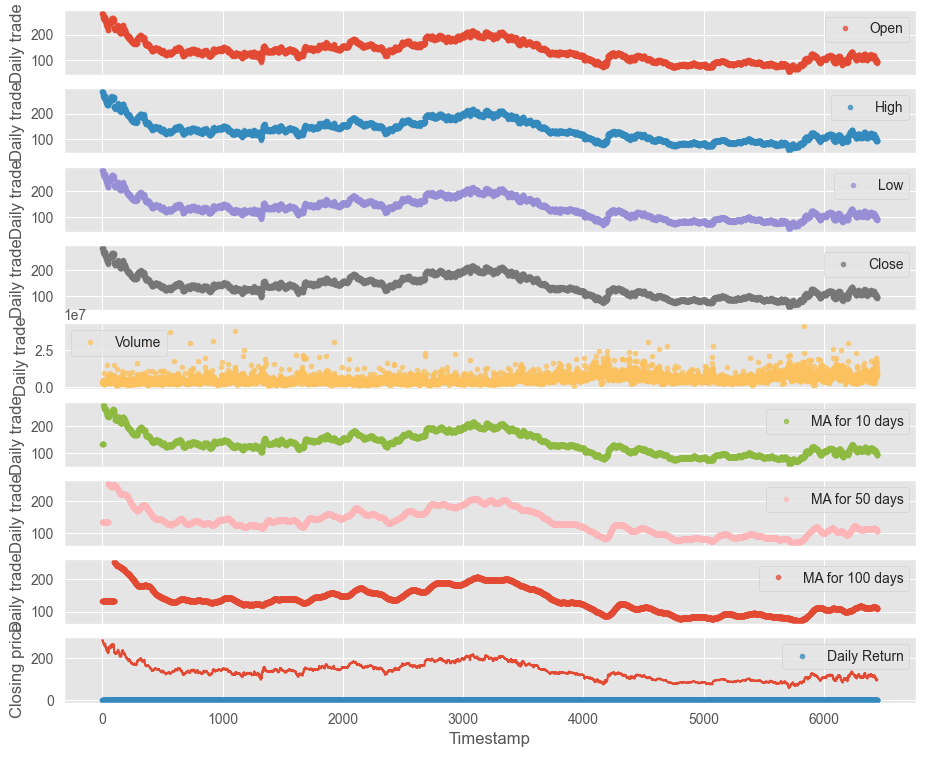

In [10]:
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

data.shape
data.size
data.describe(include='all').T
data.dtypes
data.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(data['Daily Return'].dropna(),bins=100,color='green')
plt.show()

# No idea what this is about
date= data.index
#closing_df1 = pd.DataFrame(data['Close'])
# close1  = closing_df1.rename(columns={"Close": "data_close"})
# close2=pd.concat([date,close1],axis=1)
# close2.head()

data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

data.nunique()

data.sort_index(axis=1,ascending=True)

cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

data.isnull().sum()

After that, we'll visualize the data for understanding, this is shown below...

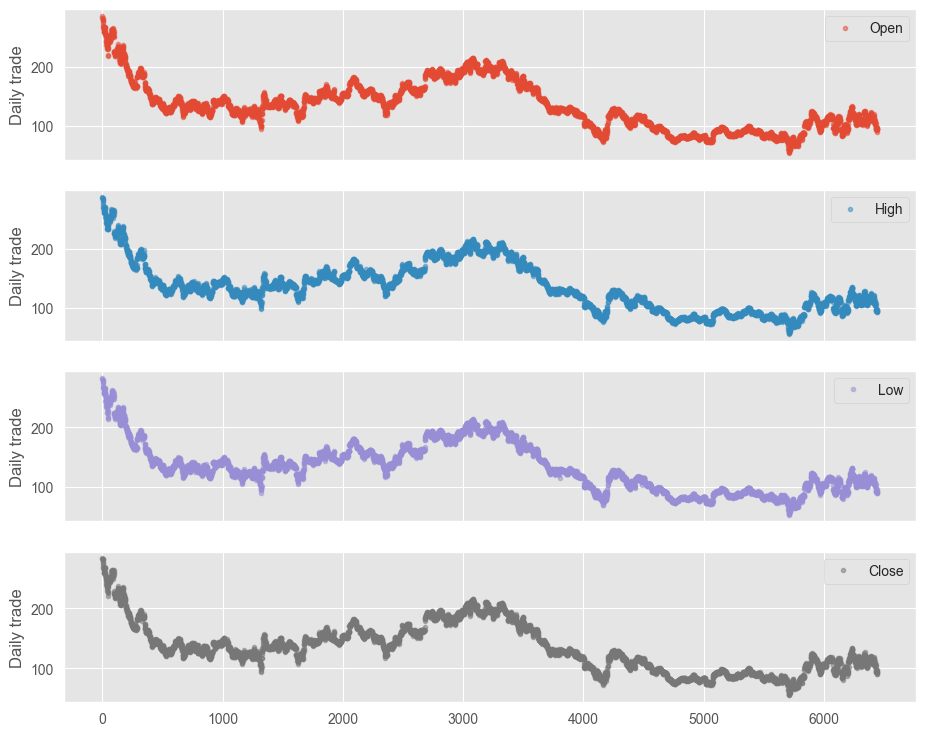

In [11]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Then we'd print the data after making changes and dropping null data

      Unnamed: 0     Open      High       Low   Close    Volume  \
0              0  285.000  286.9100  282.9400  283.21   3534110   
1              1  281.150  284.7899  281.0001  283.05   3069556   
2              2  279.305  284.5000  278.6657  281.83   3685321   
3              3  278.205  279.8400  275.8300  277.22   3243824   
4              4  281.530  283.0600  279.8300  281.03   3418007   
...          ...      ...       ...       ...     ...       ...   
6442        6442   92.750   92.9400   90.1900   90.25  13737600   
6443        6443   94.440   94.4400   90.0000   91.56  16697600   
6444        6444   95.870   95.9400   93.5000   94.37  10369100   
6445        6445   96.750   96.8100   93.6900   94.81  11105400   
6446        6446   98.500   98.8100   96.3700   96.75   9551800   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0         134.426733       134.13065       133.770091     -0.000030  
1         134.426733       134.13065       133.770091  

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,6447.0,3.223000e+03,1.861233e+03,0.000000e+00,1.611500e+03,3.223000e+03,4.834500e+03,6.446000e+03
Open,6447.0,1.344246e+02,3.982868e+01,5.465000e+01,1.027800e+02,1.300100e+02,1.601300e+02,2.850000e+02
High,6447.0,1.356548e+02,4.000898e+01,5.670000e+01,1.044100e+02,1.310800e+02,1.613700e+02,2.869100e+02
Low,6447.0,1.332786e+02,3.967255e+01,5.401000e+01,1.013350e+02,1.289500e+02,1.590975e+02,2.829400e+02
Close,6447.0,1.345006e+02,3.988315e+01,5.507000e+01,1.029000e+02,1.300200e+02,1.602400e+02,2.832100e+02
Volume,6447.0,5.866857e+06,3.286362e+06,1.027500e+06,3.713950e+06,5.010600e+06,7.070184e+06,4.120730e+07
MA for 10 days,6447.0,1.344267e+02,3.959221e+01,5.826300e+01,1.034185e+02,1.299340e+02,1.598110e+02,2.771910e+02
MA for 50 days,6447.0,1.341306e+02,3.859064e+01,6.937740e+01,1.040432e+02,1.300960e+02,1.584861e+02,2.548992e+02
MA for 100 days,6447.0,1.337701e+02,3.757384e+01,7.049900e+01,1.051397e+02,1.316523e+02,1.583183e+02,2.528525e+02
Daily Return,6447.0,-3.016187e-05,1.654917e-02,-1.147636e-01,-7.653563e-03,-3.549666e-04,7.194869e-03,1.839899e-01


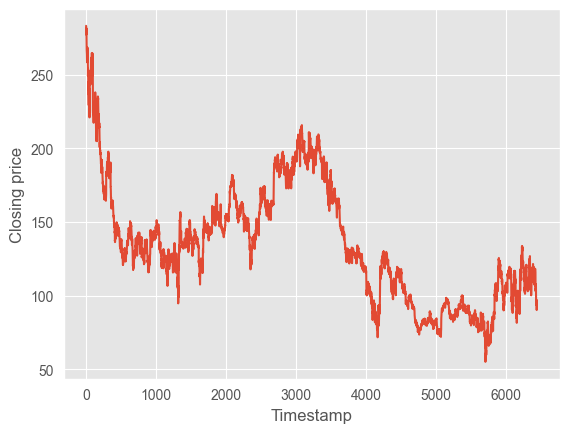

In [12]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

5076
1269


# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [14]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0091 - mae: 0.0691 - mse: 0.0091 - val_loss: 0.0023 - val_mae: 0.0350 - val_mse: 0.0023
Epoch 2/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - mae: 0.0401 - mse: 0.0029 - val_loss: 0.0025 - val_mae: 0.0373 - val_mse: 0.0025
Epoch 3/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - mae: 0.0385 - mse: 0.0027 - val_loss: 0.0019 - val_mae: 0.0325 - val_mse: 0.0019
Epoch 4/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - mae: 0.0351 - mse: 0.0022 - val_loss: 0.0019 - val_mae: 0.0332 - val_mse: 0.0019
Epoch 5/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mae: 0.0346 - mse: 0.0022 - val_loss: 0.0017 - val_mae: 0.0307 - val_mse: 0.0017
Epoch 6/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - mae: 0.0360 - mse: 0.0023 - val_loss: 0.0017 - val_mae: 0.0302 - val_mse: 0.0017
Epoch 7/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - mae: 0.0333 - mse: 0.0020 - val

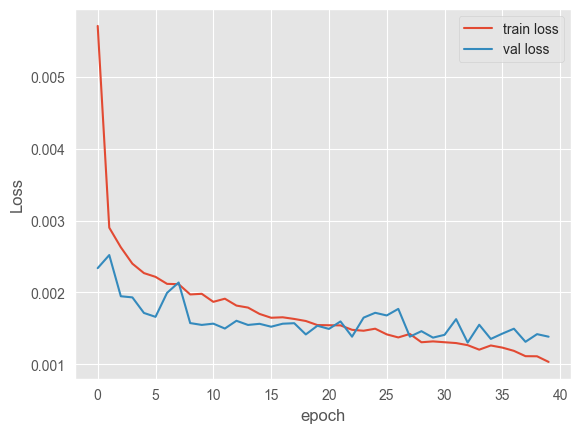

In [15]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

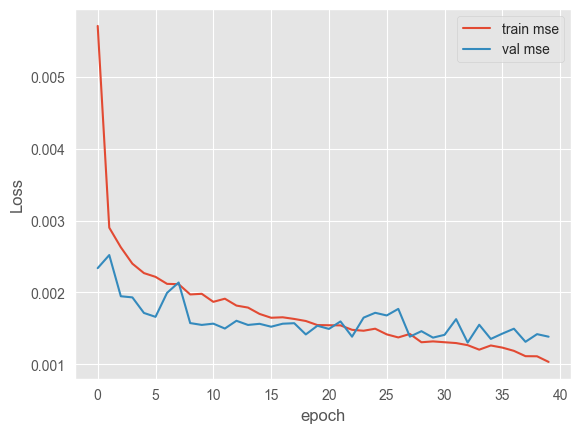

In [16]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

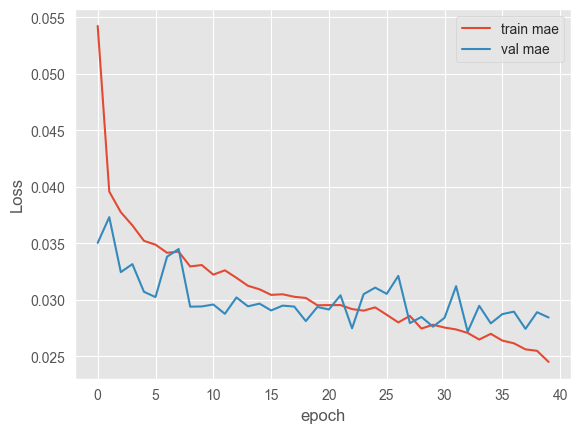

In [17]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

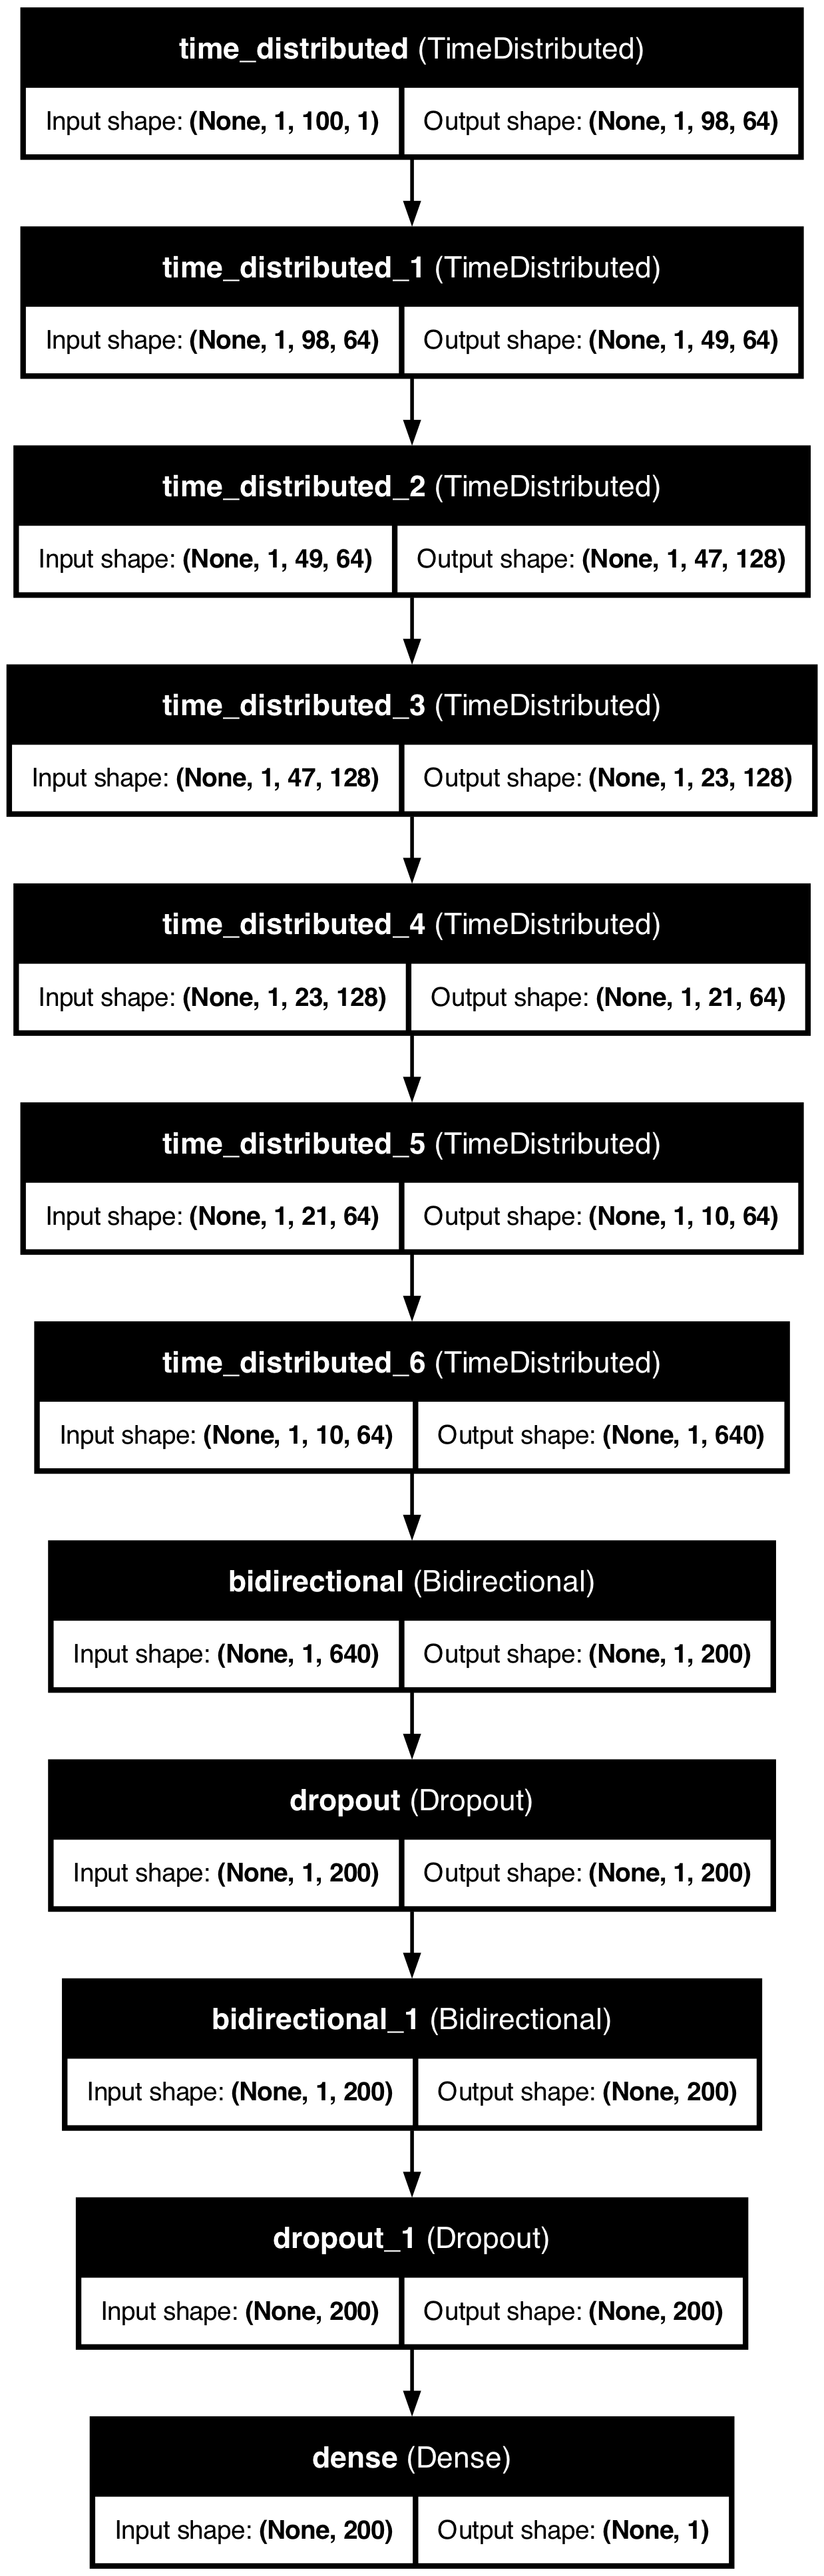

In [18]:

from tabulate import tabulate
from IPython.display import display, HTML, Image
from tensorflow.keras.utils import plot_model


# use `which dot` to check for installation
def check_graphviz():
    """Returns True if both PyDot and Graphviz are available."""
    try:
        import pydot
        # Attempt to create an image of a blank graph
        # to check the pydot/graphviz installation.
        pydot.Dot.create(pydot.Dot())
        return True
    except (OSError, pydot.PydotException) as e:
        print(f"Graphviz or PyDot is not installed or not found: {e}") 
        return False


assert check_graphviz(), "graphviz CLI is not installed or not found."

def keras_summary_to_html(model):
    summary_lines = []
    model.summary(print_fn=lambda x: summary_lines.append(x))
    # Remove the first and last lines (header/footer)
    table_lines = summary_lines[1:-4]
    table = [line.split() for line in table_lines if line.strip()]
    html = tabulate(table, tablefmt='html')
    display(HTML(html))


# After the model has been constructed, we'll summarise it
keras_summary_to_html(model)
plot_model(model, to_file='./model.png', show_shapes=True, show_layer_names=True)

# 
display(Image(filename='model.png', width=450))

In [19]:
model.evaluate(test_X, test_Y)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mae: 0.0281 - mse: 0.0013


[0.001384637551382184, 0.001384637551382184, 0.028443407267332077]

In [20]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error


# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

def print_metrics(test_Y, yhat_probs):

    var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
    print('Variance: %f' % var)

    r2 = r2_score(test_Y, yhat_probs)
    print('R2 Score: %f' % r2)

    var2 = max_error(test_Y, yhat_probs)
    print('Max Error: %f' % var2)

    # More statistics added
    y_true = test_Y
    y_pred = yhat_probs
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = (abs((y_true - y_pred) / y_true).mean()) * 100
    medae = median_absolute_error(y_true, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"R² Score: {r2:.6f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.6f}%")
    print(f"Median Absolute Error: {medae:.6f}")


print_metrics(test_Y.reshape(-1,1), yhat_probs)




Variance: 0.926634
R2 Score: 0.924601
Max Error: 0.178778
Mean Absolute Error (MAE): 0.028443
Mean Squared Error (MSE): 0.001385
Root Mean Squared Error (RMSE): 0.001385
R² Score: 0.924601
Mean Absolute Percentage Error (MAPE): inf%
Median Absolute Error: 0.022221


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


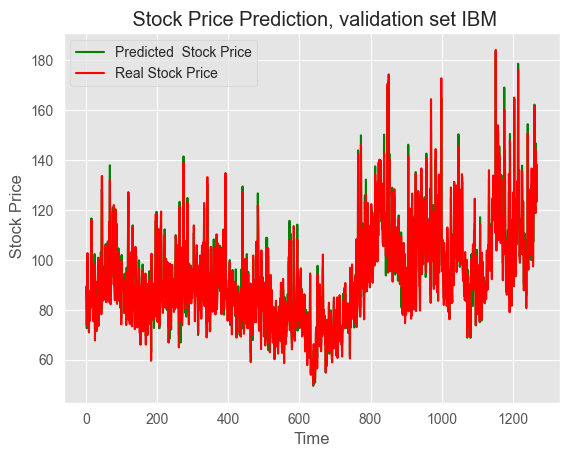

In [21]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(f' Stock Price Prediction, validation set {TICKER}')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Testing part

In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

In [22]:
# First we need to save a model
model.save("model.keras")

In [23]:
# Load model
new_model = tf.keras.models.load_model("./model.keras")

In [24]:

keras_summary_to_html(new_model)

In [25]:
# For data preprocessing and analysis part
#data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
#data2 = pd.read_csv('../input/nifty50-stock-market-data/SBIN.csv')
#data2 = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ACTG.csv')

CROSS_VALIDATION_TICKER = 'MSFT'  # Microsoft Corporation

if not os.path.exists('data2.csv'):
    print("Data file not found. Downloading stock data...")
    cv1 = request_stock_price_list(CROSS_VALIDATION_TICKER, 'full', ALPHA_VANTAGE_API_KEY)
    print("Data has been successfully downloaded...")
    cv1.to_csv('data2.csv')
else:
    print("Using cached data2 file...")

data2 = pd.read_csv('./data2.csv', parse_dates=['date'])

print("Time period is from {} to {}".format(data2['date'].min(), data2['date'].max()))

# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)
data2.head()
df2 = data2.drop('date', axis=1)



print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

Using cached data2 file...
Time period is from 1999-11-01 00:00:00 to 2025-06-18 00:00:00
      Unnamed: 0     open      high     low   close    volume
0              0  478.000  481.0000  474.46  480.24  17526452
1              1  475.395  478.7399  474.08  478.04  15414128
2              2  475.210  480.6943  475.00  479.14  15626104
3              3  476.410  479.1800  472.76  474.96  16814456
4              4  475.020  480.4150  473.52  478.87  18950582
...          ...      ...       ...     ...     ...       ...
6442        6442   91.810   92.8700   90.50   91.56  35083700
6443        6443   92.310   92.7500   90.31   91.75  27119700
6444        6444   92.940   93.5000   91.50   92.00  22258500
6445        6445   92.750   94.5000   91.94   92.56  23174500
6446        6446   93.250   94.1900   92.12   92.37  26630600

[6447 rows x 6 columns]
5076
1269


In [26]:
model.evaluate(test_X, test_Y)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291 - mae: 0.0813 - mse: 0.0291


[0.03356264904141426, 0.03356264904141426, 0.10199764370918274]

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


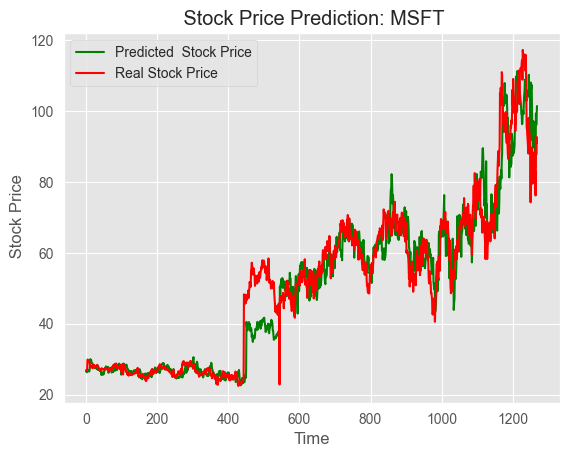

In [27]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(f' Stock Price Prediction: {CROSS_VALIDATION_TICKER}')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Cross validation statistics 

- See how well we did with another stock

In [41]:
print("Cross validation metrics for {}:".format(CROSS_VALIDATION_TICKER))
print_metrics(test_label, predicted)

Cross validation metrics for MSFT:
Variance: 0.916268
R2 Score: 0.914528
Max Error: 26.020889
Mean Absolute Error (MAE): 4.243379
Mean Squared Error (MSE): 42.151807
Root Mean Squared Error (RMSE): 42.151807
R² Score: 0.914528
Mean Absolute Percentage Error (MAPE): 7.471115%
Median Absolute Error: 2.199758


**Note**: The following step was disabled due to Python package version incompatibilities.

In [29]:
# Converting model from HDF5 format to TFJS format...
# !pip install tensorflowjs[wizard]
# Need to be done on a CLI and not in notebook
# !tensorflowjs_converter --input_format=keras /kaggle/working/model.h5 /kaggle/working/model-tjs

# Exploratory data analysis

This section is exploratory data analysis on the dataset collected. This is just for analysing the data...

In [30]:
dataX = pd.read_csv('./data.csv', parse_dates=['date'])
dataY = dataX.copy()
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6447 entries, 0 to 6446
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  6447 non-null   int64         
 1   open        6447 non-null   float64       
 2   high        6447 non-null   float64       
 3   low         6447 non-null   float64       
 4   close       6447 non-null   float64       
 5   volume      6447 non-null   int64         
 6   date        6447 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 352.7 KB


In [31]:
dataX.head()

,Unnamed: 0,open,high,low,close,volume,date
0,0,285.000,286.9100,282.9400,283.21,3534110,2025-06-18
1,1,281.150,284.7899,281.0001,283.05,3069556,2025-06-17
2,2,279.305,284.5000,278.6657,281.83,3685321,2025-06-16
3,3,278.205,279.8400,275.8300,277.22,3243824,2025-06-13
4,4,281.530,283.0600,279.8300,281.03,3418007,2025-06-12


In [32]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,volume,date
891,891,118.62,119.610,117.53,118.50,8949795,2021-11-29
892,892,115.00,116.335,114.56,115.81,3322012,2021-11-26
893,893,116.16,117.270,116.08,116.73,3220802,2021-11-24
894,894,116.79,117.940,116.04,116.79,4914995,2021-11-23
895,895,116.00,118.810,115.19,116.47,6417218,2021-11-22
...,...,...,...,...,...,...,...
1368,1368,134.51,135.860,133.92,135.31,4345952,2020-01-08
1369,1369,133.69,134.960,133.40,134.19,3267592,2020-01-07
1370,1370,133.42,134.240,133.20,134.10,2421128,2020-01-06
1371,1371,133.57,134.860,133.56,134.34,2373470,2020-01-03


In [33]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,volume,date
1373,1373,132.53,134.12,132.40,134.04,3777504,2019-12-31
1374,1374,135.20,135.30,132.50,132.81,4118929,2019-12-30
1375,1375,135.00,135.75,134.87,135.27,2752185,2019-12-27
1376,1376,134.98,135.31,134.65,134.91,2129654,2019-12-26
1377,1377,135.61,135.62,134.61,134.98,1202087,2019-12-24
...,...,...,...,...,...,...,...
1871,1871,162.66,163.91,161.70,163.47,5101023,2018-01-08
1872,1872,162.44,162.90,161.10,162.49,5162075,2018-01-05
1873,1873,159.65,162.32,159.37,161.70,7363843,2018-01-04
1874,1874,157.34,159.81,156.33,158.49,9439063,2018-01-03


In [34]:
dataX.describe()

,Unnamed: 0,open,high,low,close,volume,date
count,482.000000,482.000000,482.000000,482.000000,482.000000,4.820000e+02,482
mean,1131.500000,129.382080,130.691720,128.092867,129.364751,5.454950e+06,2020-12-15 15:17:10.705394432
min,891.000000,94.600000,97.740000,90.560000,94.770000,1.761122e+06,2020-01-02 00:00:00
25%,1011.250000,121.250000,122.623500,120.102500,121.105000,3.644222e+06,2020-06-24 06:00:00
50%,1131.500000,126.325000,127.320000,125.045000,126.160000,4.655173e+06,2020-12-14 12:00:00
75%,1251.750000,139.672500,140.467500,138.757500,139.572500,6.115408e+06,2021-06-08 18:00:00
max,1372.000000,156.820000,158.750000,155.420000,156.760000,3.806353e+07,2021-11-29 00:00:00
std,139.285678,11.382857,11.114856,11.592091,11.353678,3.339331e+06,NaN


In [35]:
dataY.describe()

,Unnamed: 0,open,high,low,close,volume,date
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02,503
mean,1624.000000,140.470239,141.512740,139.348929,140.416143,4.590926e+06,2018-12-31 18:45:05.367793408
min,1373.000000,108.000000,111.000000,105.940000,107.570000,1.202087e+06,2018-01-02 00:00:00
25%,1498.500000,134.485000,135.305000,133.570000,134.360000,3.067226e+06,2018-07-02 12:00:00
50%,1624.000000,140.720000,141.780000,139.790000,140.850000,3.783614e+06,2019-01-02 00:00:00
75%,1749.500000,146.635000,147.300000,145.540000,146.385000,5.033500e+06,2019-07-02 12:00:00
max,1875.000000,170.000000,171.130000,168.150000,169.120000,2.206367e+07,2019-12-31 00:00:00
std,145.347859,11.156349,11.144803,11.149435,11.121441,2.880224e+06,NaN


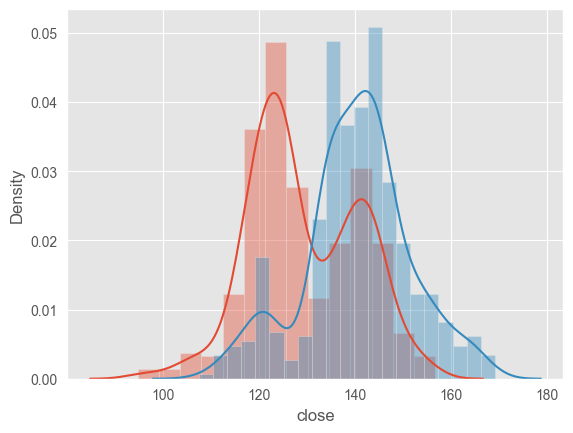

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error

sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

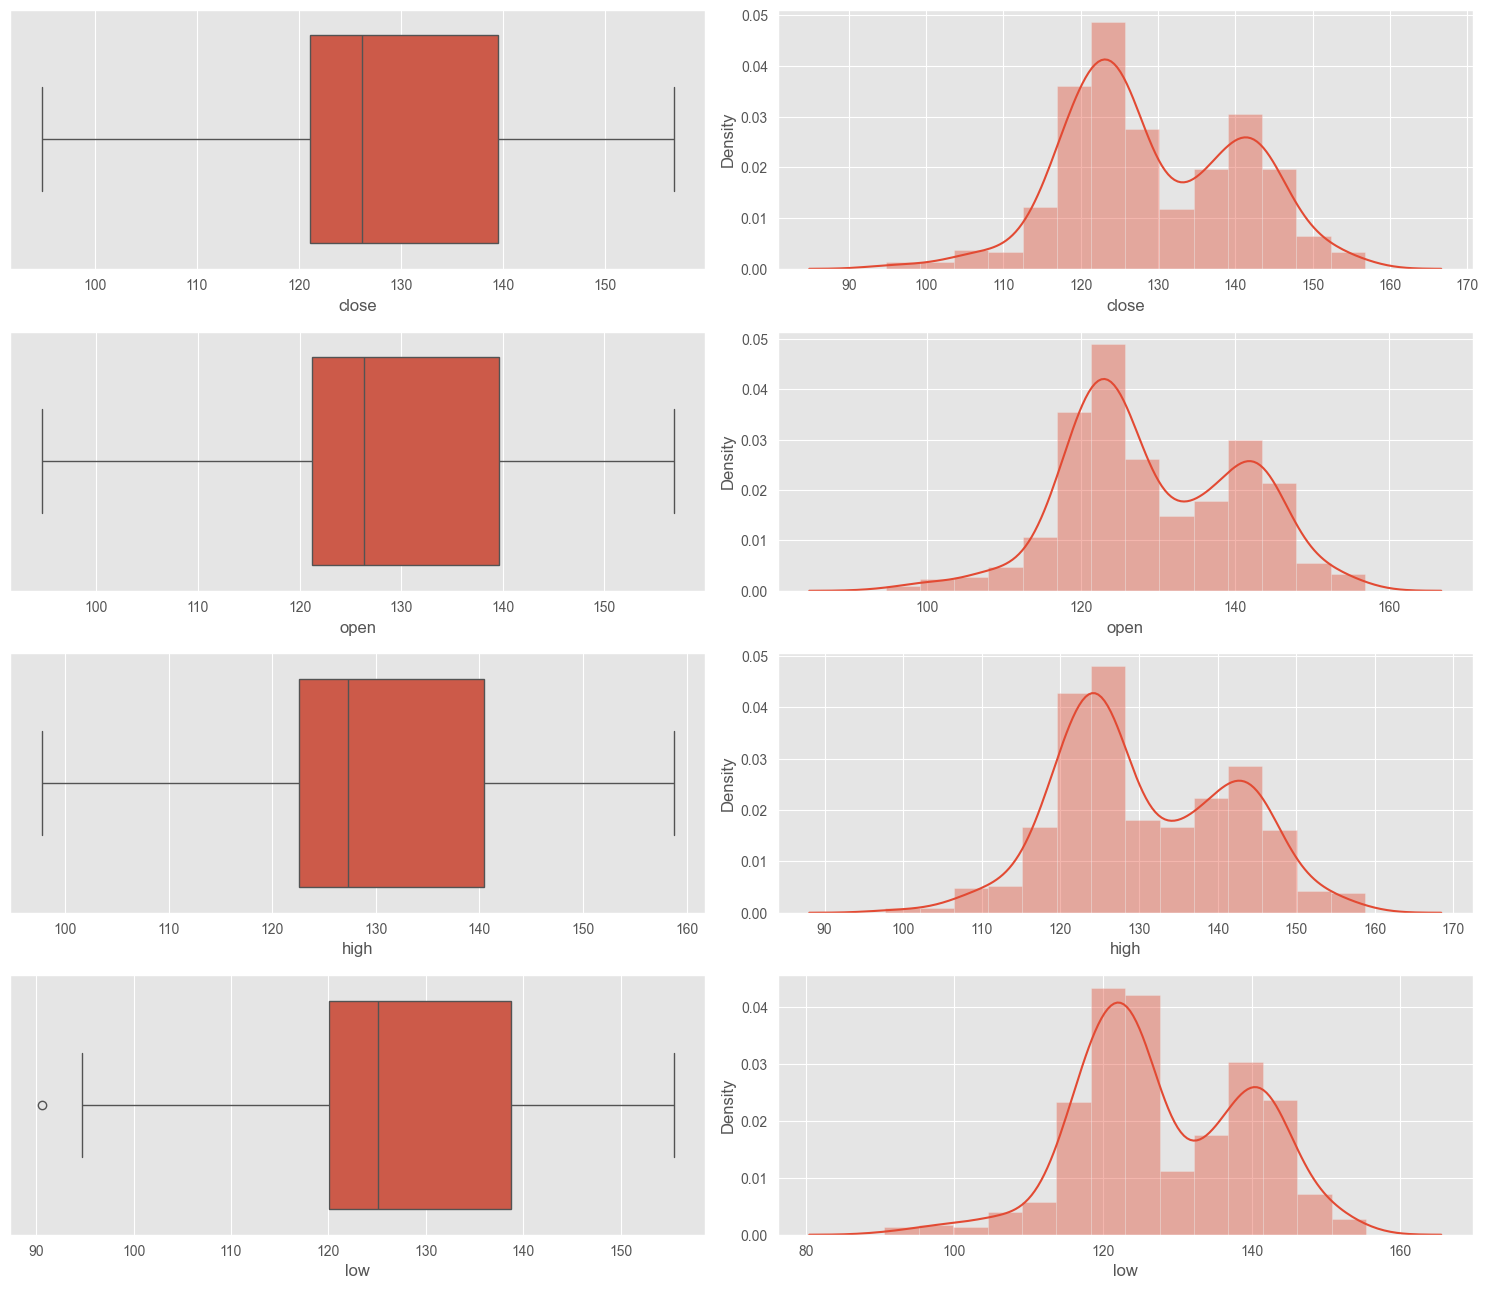

In [37]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

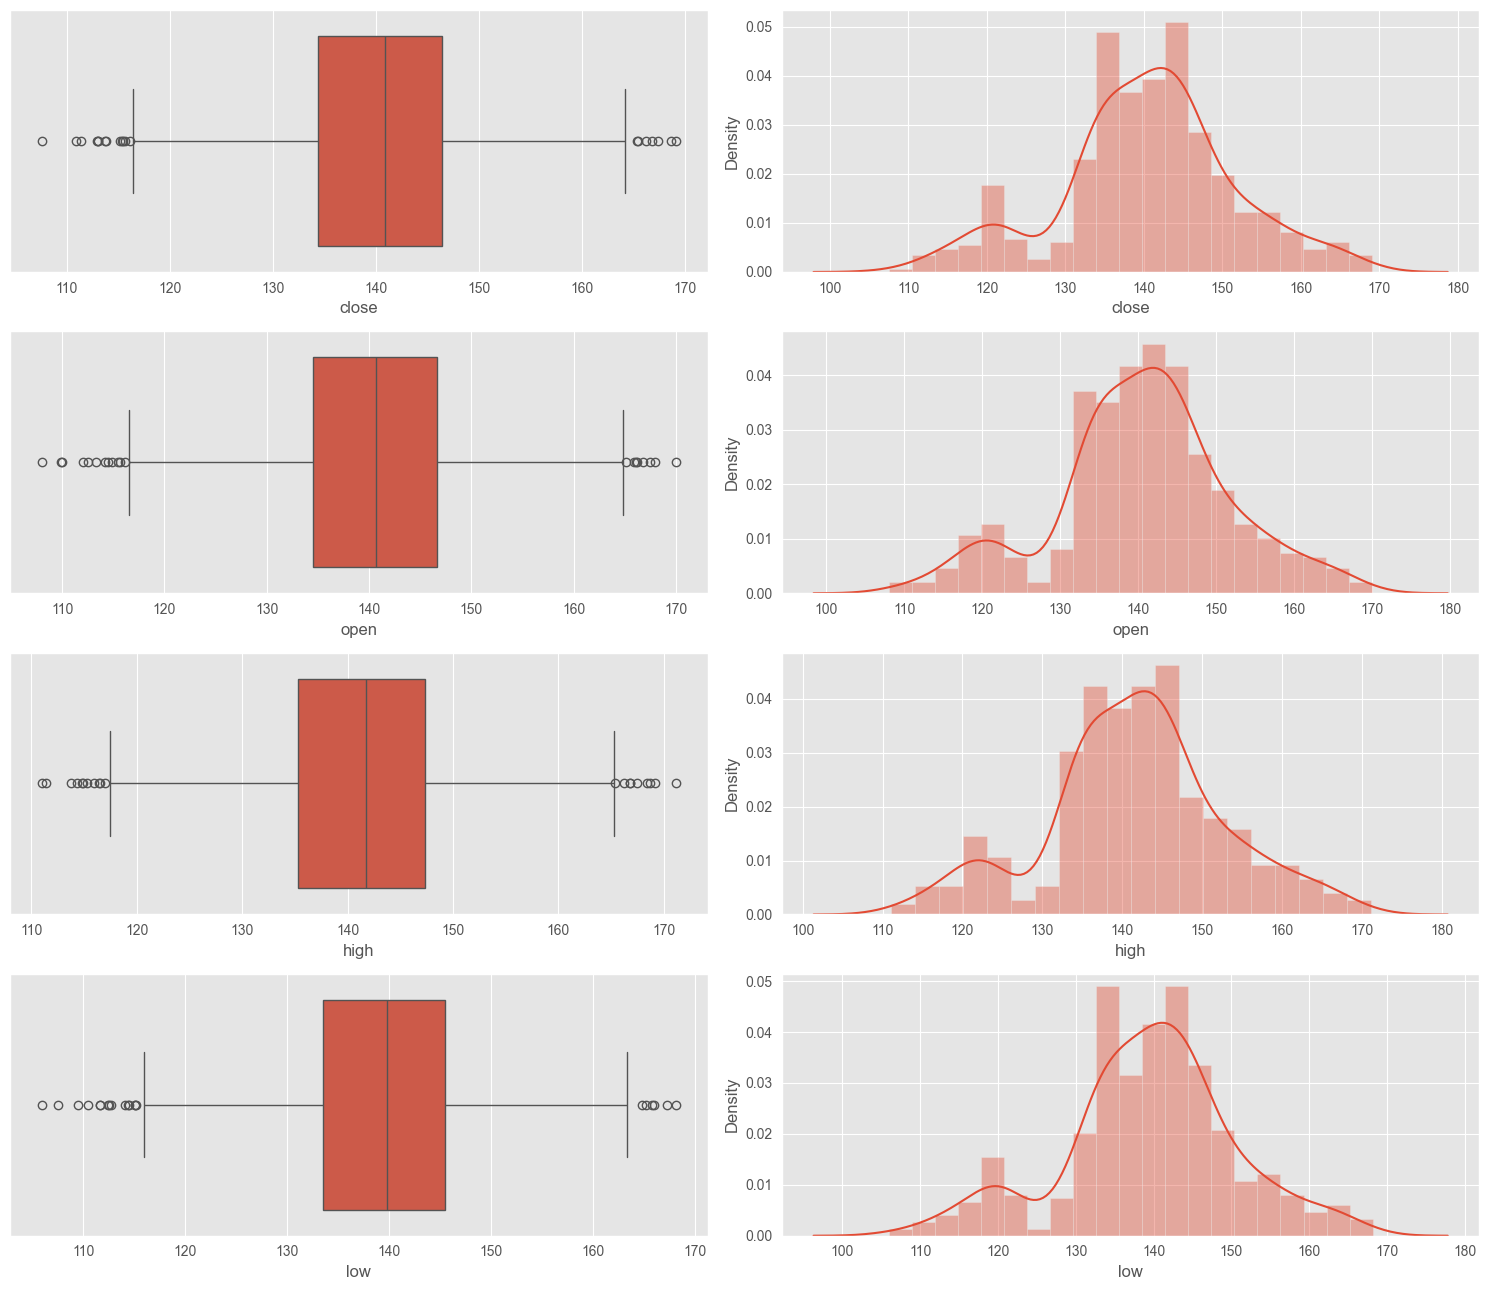

In [38]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

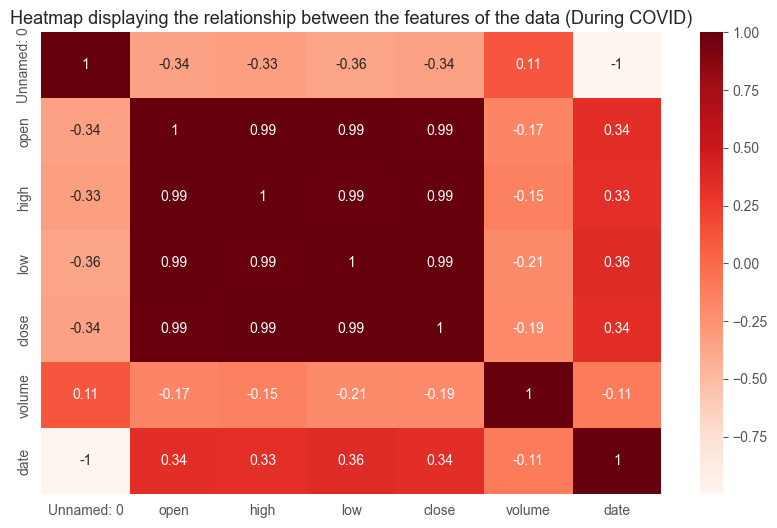

In [39]:
plt.figure(figsize=(10,6))

sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

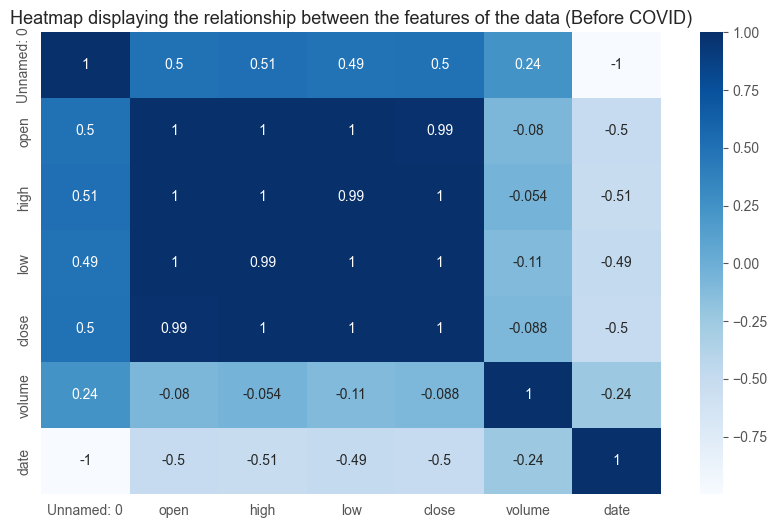

In [40]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()